In [3]:
from keras.preprocessing.text import Tokenizer
from gensim.models.fasttext import FastText
import numpy as np
import matplotlib.pyplot as plt
import nltk
from string import punctuation
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize
from nltk import WordPunctTokenizer

import wikipedia
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
en_stop = set(nltk.corpus.stopwords.words('english'))

%matplotlib inline

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ankit.dubey\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ankit.dubey\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ankit.dubey\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
artificial_intelligence = wikipedia.page("Artificial Intelligence").content
#machine_learning = wikipedia.page("Machine Learning").content
deep_learning = wikipedia.page("Deep Learning").content
neural_network = wikipedia.page("Neural Network").content

artificial_intelligence = sent_tokenize(artificial_intelligence)
#machine_learning = sent_tokenize(machine_learning)
deep_learning = sent_tokenize(deep_learning)
neural_network = sent_tokenize(neural_network)

#artificial_intelligence.extend(machine_learning)
artificial_intelligence.extend(deep_learning)
artificial_intelligence.extend(neural_network)

In [8]:
import re

stemmer = WordNetLemmatizer()

def preprocess_text(document):
    document = re.sub(r'W', ' ', str(document))
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document)
    document = re.sub(r'\s+', ' ', document, flags=re.I)
    document = re.sub(r'^b\s+', '', document)
    document = document.lower()
    
    tokens = document.split()
    tokens = [stemmer.lemmatize(word) for word in tokens]
    tokens = [word for word in tokens if word not in en_stop]
    tokens = [word for word in tokens if len(word) > 3]
    
    preprocessed_text = ' '.join(tokens)
    
    return preprocessed_text

In [9]:
final_corpus = [preprocess_text(sentence) for sentence in artificial_intelligence if sentence.strip() !='']
word_punctuation_tokenizer = nltk.WordPunctTokenizer()
word_tokenized_corpus = [word_punctuation_tokenizer.tokenize(sent) for sent in final_corpus]

In [13]:
%%time
embedding_size = 60
window_size = 40
min_word = 5
down_sampling = 1e-2

ft_model = FastText(word_tokenized_corpus,
                   size=embedding_size,
                   window=window_size,
                   min_count=min_word,
                   sample=down_sampling,
                   sg=1,
                   iter=100)

Wall time: 23.2 s


In [14]:
print(ft_model.wv['convolution'])

[-0.07866699  0.37130713  0.07648889  0.31414685  0.56786615  1.0314449
  0.5247187   0.02725329  0.5003674   1.849343    0.43510252  1.0367752
  0.38215113  0.57445776  0.3075844   0.40124205  1.268822    1.1747196
 -0.09633882  0.8573055  -0.30654305 -0.38291526 -0.55183977  0.20077093
  0.17717676 -0.16297822 -0.05875342 -0.61936635 -0.53664285  0.22176027
 -0.2108391  -0.22321855 -0.9190714  -0.6157373  -0.04053863 -0.37945074
 -0.72270715 -0.01986952 -1.040852   -0.03169518 -0.38534817  0.1141667
  0.31587738  0.03858675 -0.94437206  0.19452316 -0.4913997   0.2785089
 -0.33315587  0.4962105   0.30289802 -0.08790424  0.38218808 -0.31213245
 -0.13935074 -0.10680815  0.35467362 -0.91481006 -0.21629381 -0.2909696 ]


In [15]:
semantically_similar_words = {words: [item[0] for item in ft_model.wv.most_similar([words], topn=5)]
                             for words in ['artificial', 'convolution', 'machine', 'gradient', 'neural']}

for k, v in semantically_similar_words.items():
    print(k+":"+str(v))

artificial:['intelligence', 'simulated', 'simulate', 'machine', 'moral']
convolution:['convolutional', 'vision', 'gradient', 'supervised', 'revolution']
machine:['ethic', 'intelligence', ',', 'artificial', 'ability']
gradient:['structure', 'avoid', 'context', 'variety', 'convolutional']
neural:['network', 'networks', 'biological', 'model', 'deep']


In [16]:
from sklearn.decomposition import PCA

all_similar_words = sum([[k] + v for k, v in semantically_similar_words.items()], [])

print(all_similar_words)
print(type(all_similar_words))
print(len(all_similar_words))

['artificial', 'intelligence', 'simulated', 'simulate', 'machine', 'moral', 'convolution', 'convolutional', 'vision', 'gradient', 'supervised', 'revolution', 'machine', 'ethic', 'intelligence', ',', 'artificial', 'ability', 'gradient', 'structure', 'avoid', 'context', 'variety', 'convolutional', 'neural', 'network', 'networks', 'biological', 'model', 'deep']
<class 'list'>
30


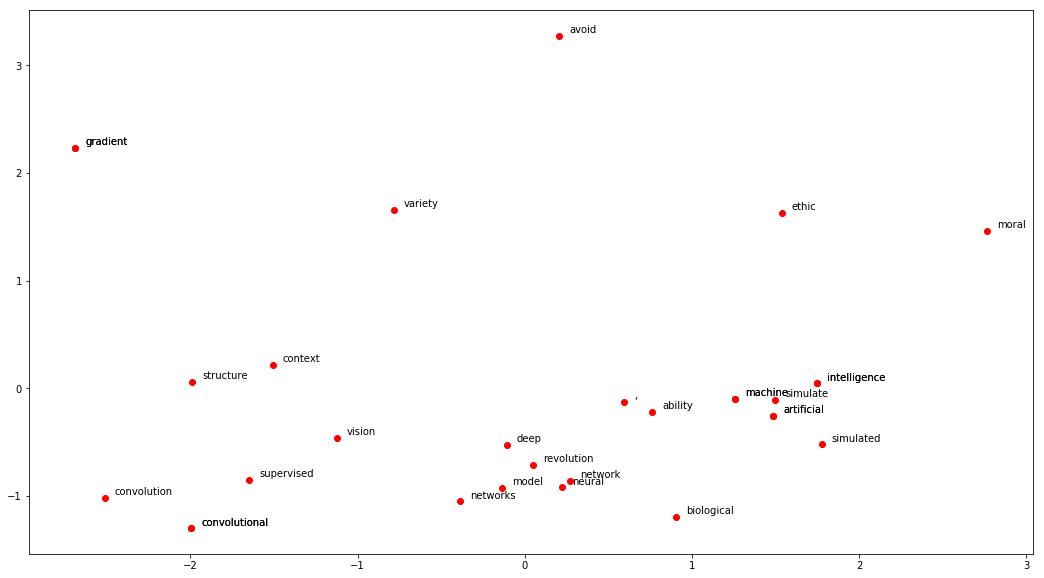

In [17]:
word_vectors = ft_model.wv[all_similar_words]

pca = PCA(n_components=2)
p_comps = pca.fit_transform(word_vectors)
word_names = all_similar_words

plt.figure(figsize=(18,10))
plt.scatter(p_comps[:, 0], p_comps[:, 1], c='red')

for word_names, x, y in zip(word_names, p_comps[:,0], p_comps[:,1]):
    plt.annotate(word_names, xy=(x+0.06, y+0.03), xytext=(0,0), textcoords='offset points')